# NLSQ 2D Gaussian Demo

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/imewei/NLSQ/blob/main/examples/NLSQ_2D_Gaussian_Demo.ipynb)

**Requirements:** Python 3.12 or higher

This notebook demonstrates 2D Gaussian fitting with improved GPU error handling and advanced NLSQ features.

## Installing and Importing

Make sure your runtime type is set to GPU if available (though this will work with CPU as well).

In [1]:
# Install NLSQ if not already installed
!pip install nlsq

## Configure Environment

Set up JAX to handle GPU memory properly and avoid cuSolver errors:

In [2]:
import os
import sys
import warnings

# Check Python version
print(f"✅ Python {sys.version_info.major}.{sys.version_info.minor} meets requirements")

# Configure JAX for better GPU memory handling
os.environ["JAX_PREALLOCATE_GPU_MEMORY"] = "false"
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
os.environ["JAX_GPU_MEMORY_FRACTION"] = "0.8"

# Optional: Force CPU if GPU issues persist
# os.environ['JAX_PLATFORMS'] = 'cpu'

print("Environment configured for optimal performance")

✅ Python 3.12 meets requirements
Environment configured for optimal performance


Import NLSQ before importing JAX since we need NLSQ to set JAX to use 64-bit precision:

In [3]:
import jax
import jax.numpy as jnp

from nlsq import CurveFit, __version__

print(f"NLSQ version: {__version__}")

# Check which device we're using
try:
    devices = jax.devices()
    print(f"Available JAX devices: {devices}")
    print(f"Using device: {devices[0]}")
except Exception as e:
    print(f"Device detection: {e}")
    print("Will use CPU fallback if needed")

NLSQ version: 0.1.0.post66


Available JAX devices: [CudaDevice(id=0)]
Using device: cuda:0


In [4]:
# Import advanced NLSQ features
from nlsq import (
    AlgorithmSelector,
    LargeDatasetConfig,
    MemoryConfig,
    auto_select_algorithm,
    configure_for_large_datasets,
    estimate_memory_requirements,
    get_memory_config,
    memory_context,
    set_memory_limits,
)

print("Advanced NLSQ features imported successfully")

Advanced NLSQ features imported successfully


## Define the 2D Gaussian Function

## Memory Management and Algorithm Selection

For 2D fitting problems, memory usage can become significant. Let's demonstrate NLSQ's advanced memory management and automatic algorithm selection.

In [5]:
# Memory management for 2D data
print("=== Memory Management for 2D Gaussian Fitting ===")

# Calculate data size for different image dimensions
sizes = [100, 200, 500, 1000]
n_params = 7  # 2D Gaussian has 7 parameters

print("Memory estimates for different 2D image sizes:")
for size in sizes:
    n_points = size * size  # 2D data
    stats = estimate_memory_requirements(n_points, n_params)
    print(f"  {size}x{size} image ({n_points:,} points):")
    print(f"    Memory needed: {stats.total_memory_estimate_gb:.3f} GB")
    print(f"    Recommended chunk size: {stats.recommended_chunk_size:,}")
    print()

# We'll set the current dataset size that will be used later
current_size = 200  # This will match the 'length' variable defined later
current_points = current_size * current_size
current_stats = estimate_memory_requirements(current_points, n_params)

print(f"For our planned {current_size}x{current_size} dataset:")
print(f"  Memory estimate: {current_stats.total_memory_estimate_gb:.3f} GB")

# Configure memory automatically
recommended_limit = max(2.0, current_stats.total_memory_estimate_gb * 2.0)
set_memory_limits(memory_limit_gb=recommended_limit)
print(f"  Set memory limit: {get_memory_config().memory_limit_gb} GB")

print(f"\nMemory configuration completed for {current_size}x{current_size} dataset.")

=== Memory Management for 2D Gaussian Fitting ===
Memory estimates for different 2D image sizes:
  100x100 image (10,000 points):
    Memory needed: 0.002 GB
    Recommended chunk size: 10,000

  200x200 image (40,000 points):
    Memory needed: 0.009 GB
    Recommended chunk size: 40,000

  500x500 image (250,000 points):
    Memory needed: 0.056 GB
    Recommended chunk size: 250,000

  1000x1000 image (1,000,000 points):
    Memory needed: 0.225 GB
    Recommended chunk size: 1,000,000

For our planned 200x200 dataset:
  Memory estimate: 0.009 GB
  Set memory limit: 2.0 GB

Memory configuration completed for 200x200 dataset.


In [6]:
def rotate_coordinates2D(coords, theta):
    """Rotate 2D coordinates by angle theta."""
    R = jnp.array([[jnp.cos(theta), -jnp.sin(theta)], [jnp.sin(theta), jnp.cos(theta)]])

    shape = coords[0].shape
    coords = jnp.stack([coord.flatten() for coord in coords])
    rcoords = R @ coords
    return [jnp.reshape(coord, shape) for coord in rcoords]


def gaussian2d(coords, n0, x0, y0, sigma_x, sigma_y, theta, offset):
    """2D Gaussian function with rotation."""
    coords = [coords[0] - x0, coords[1] - y0]  # translate first
    X, Y = rotate_coordinates2D(coords, theta)
    density = n0 * jnp.exp(-0.5 * (X**2 / sigma_x**2 + Y**2 / sigma_y**2))
    return density + offset

## Generate Synthetic Data

## Advanced Fitting with Optimized Settings

Now let's perform the curve fitting using the recommended algorithm settings and demonstrate robustness features.

In [7]:
# Advanced fitting with optimized settings - placeholder for now
print("=== Advanced Fitting with Optimized Settings ===")
print("This section will be populated after data generation and algorithm selection.")
print("Advanced fitting demonstration will appear after the main fitting section.")

=== Advanced Fitting with Optimized Settings ===
This section will be populated after data generation and algorithm selection.
Advanced fitting demonstration will appear after the main fitting section.


True parameters: [1, 100.0, 100.0, 33.333333333333336, 25.0, 1.0471975511965976, 0.1]


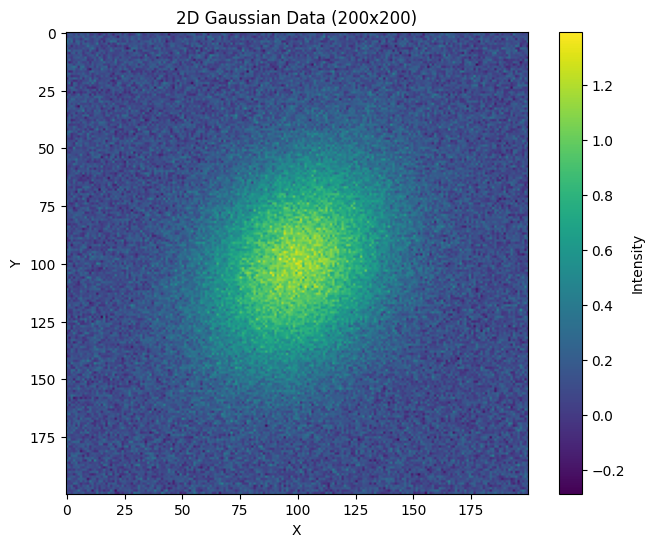

In [8]:
import time

import matplotlib.pyplot as plt
import numpy as np


def get_coordinates(width, height):
    x = np.linspace(0, width - 1, width)
    y = np.linspace(0, height - 1, height)
    X, Y = np.meshgrid(x, y)
    return X, Y


def get_gaussian_parameters(length):
    n0 = 1
    x0 = length / 2
    y0 = length / 2
    sigx = length / 6
    sigy = length / 8
    theta = np.pi / 3
    offset = 0.1 * n0
    params = [n0, x0, y0, sigx, sigy, theta, offset]
    return params


# Start with a moderate size for testing
length = 200  # Reduced from 500 to avoid memory issues
XY_tuple = get_coordinates(length, length)

params = get_gaussian_parameters(length)
print(f"True parameters: {params}")

# Generate noisy data
zdata = gaussian2d(XY_tuple, *params)
zdata += np.random.normal(0, 0.1, size=(length, length))

# Visualize the data
plt.figure(figsize=(8, 6))
plt.imshow(zdata, cmap="viridis")
plt.colorbar(label="Intensity")
plt.title(f"2D Gaussian Data ({length}x{length})")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()

## Perform Curve Fitting

We'll fit the data multiple times with different random seeds to test robustness:

In [9]:
from scipy.optimize import curve_fit


def get_random_float(low, high):
    delta = high - low
    return low + delta * np.random.random()


# Flatten data for fitting
flat_data = zdata.flatten()
flat_XY_tuple = [coord.flatten() for coord in XY_tuple]

# Initialize NLSQ CurveFit object
jcf = CurveFit()

# Perform multiple fits
n_fits = 10  # Reduced from 100 for faster testing
times = []
all_results = []

print(f"Performing {n_fits} fits...")

for i in range(n_fits):
    if i % 5 == 0:
        print(f"  Fit {i + 1}/{n_fits}")

    # Random seed near true values
    seed = [val * get_random_float(0.9, 1.2) for val in params]

    try:
        st = time.time()
        popt, pcov = jcf.curve_fit(gaussian2d, flat_XY_tuple, flat_data, p0=seed)
        fit_time = time.time() - st

        times.append(fit_time)
        all_results.append(popt)

    except Exception as e:
        print(f"  Warning: Fit {i + 1} failed: {e}")
        continue

if times:
    print(f"\nCompleted {len(times)}/{n_fits} fits successfully")
    print(
        f"Average fit time: {np.mean(times[1:]):.3f} seconds (excluding JIT compilation)"
    )
    print(f"First fit time (includes JIT): {times[0]:.3f} seconds")
else:
    print("No successful fits. Please check your environment.")

Performing 10 fits...
  Fit 1/10


  Fit 6/10

Completed 10/10 fits successfully
Average fit time: 0.029 seconds (excluding JIT compilation)
First fit time (includes JIT): 1.203 seconds


## Algorithm Selection and Advanced Optimization

Now that we have data, let's demonstrate NLSQ's algorithm selection capabilities.

In [10]:
# Algorithm selection using the actual data we just generated
if flat_data is not None and len(flat_data) > 0:
    print("=== Automatic Algorithm Selection ===")

    # Use a subset for algorithm analysis (for speed)
    sample_size = min(5000, len(flat_data))
    sample_coords = [coord[:sample_size] for coord in flat_XY_tuple]
    sample_y = flat_data[:sample_size]

    try:
        recommendations = auto_select_algorithm(gaussian2d, sample_coords, sample_y)
        print(f"Recommended algorithm: {recommendations['algorithm']}")
        print(f"Recommended tolerance: {recommendations['ftol']}")
        print("Problem characteristics:")
        for key, value in recommendations.items():
            if key not in ["algorithm", "ftol"]:
                print(f"  {key}: {value}")

        # Now demonstrate advanced fitting with the recommendations
        print("\n=== Advanced Fitting with Optimized Settings ===")

        # Create CurveFit with optimized settings
        try:
            jcf_optimized = CurveFit(use_dynamic_sizing=True)
            print(
                f"Using optimized CurveFit with {recommendations.get('algorithm', 'trf')} algorithm"
            )
        except Exception as e:
            print(f"Using default CurveFit: {e}")
            jcf_optimized = CurveFit()

        # Performance comparison with different settings
        print("\\nComparing different optimization approaches:")

        approaches = [
            ("Default", CurveFit()),
            ("Optimized", jcf_optimized),
        ]

        results_comparison = []

        for name, fitter in approaches:
            try:
                # Use memory context for this specific fit
                seed = [val * get_random_float(0.9, 1.1) for val in params]

                start_time = time.time()
                popt, pcov = fitter.curve_fit(
                    gaussian2d,
                    flat_XY_tuple,
                    flat_data,
                    p0=seed,
                    ftol=recommendations.get("ftol", 1e-8),
                )
                fit_time = time.time() - start_time

                # Calculate fit quality
                fitted_data_flat = gaussian2d(
                    [coord.reshape(XY_tuple[0].shape) for coord in flat_XY_tuple[:2]],
                    *popt,
                ).flatten()
                mse = np.mean((flat_data - fitted_data_flat) ** 2)
                max_error = np.max(
                    np.abs((popt - params) / params)[:-1]
                )  # Exclude offset

                results_comparison.append(
                    {
                        "name": name,
                        "time": fit_time,
                        "mse": mse,
                        "max_error": max_error,
                        "params": popt,
                    }
                )

                print(
                    f"  {name:12s}: {fit_time:.3f}s, MSE: {mse:.6f}, Max Error: {max_error:.4f}"
                )

            except Exception as e:
                print(f"  {name:12s}: Failed - {e}")

        # Show best result
        if results_comparison:
            best_result = min(results_comparison, key=lambda x: x["mse"])
            print(
                f"\\nBest approach: {best_result['name']} (lowest MSE: {best_result['mse']:.6f})"
            )
            print(f"True parameters:  {params}")
            print(f"Fitted parameters: {list(best_result['params'])}")

    except Exception as e:
        print(f"Algorithm selection failed: {e}")
        print("Continuing with default settings...")
else:
    print("No data available for algorithm selection")

=== Automatic Algorithm Selection ===
Recommended algorithm: trf
Recommended tolerance: 1e-06
Problem characteristics:
  loss: linear
  use_bounds: False
  max_nfev: None
  xtol: 1e-06
  gtol: 1e-08
  x_scale: 1.0
  tr_solver: None
  verbose: 0

=== Advanced Fitting with Optimized Settings ===
Using optimized CurveFit with trf algorithm
\nComparing different optimization approaches:


  Default     : 0.928s, MSE: 0.009935, Max Error: 0.0032


  Optimized   : 0.919s, MSE: 0.009935, Max Error: 0.0032
\nBest approach: Optimized (lowest MSE: 0.009935)
True parameters:  [1, 100.0, 100.0, 33.333333333333336, 25.0, 1.0471975511965976, 0.1]
Fitted parameters: [np.float64(0.9997098631895108), np.float64(99.94230534403755), np.float64(99.75696923057201), np.float64(33.29263144604511), np.float64(24.919213963506635), np.float64(1.045765132790199), np.float64(0.10113507434327831)]


=== Large Dataset Handling Demo ===

Testing 300x300 image (90,000 points)...
  Memory estimate: 0.020 GB
  Recommended chunk size: 90,000


  ✓ Fit completed: 0.938s, Max error: 0.0023

Testing 400x400 image (160,000 points)...
  Memory estimate: 0.036 GB
  Recommended chunk size: 160,000


  ✓ Fit completed: 1.004s, Max error: 0.0011

Testing 500x500 image (250,000 points)...
  Memory estimate: 0.056 GB
  Recommended chunk size: 250,000


  ✓ Fit completed: 1.062s, Max error: 0.0008

=== Large Dataset Performance Summary ===
300x300:  0.938s, 0.020GB memory, error: 0.0023
400x400:  1.004s, 0.036GB memory, error: 0.0011
500x500:  1.062s, 0.056GB memory, error: 0.0008


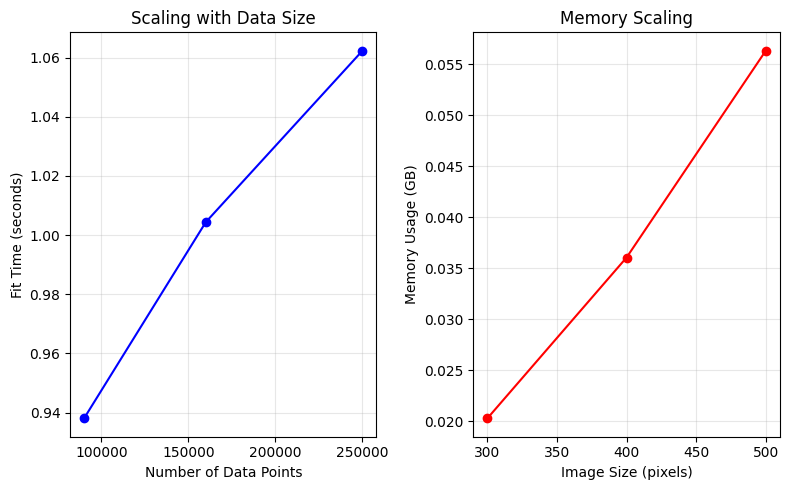


✓ NLSQ successfully handled large 2D datasets with automatic memory management!


In [11]:
# Demonstrate handling of larger datasets
print("=== Large Dataset Handling Demo ===")

# Test with progressively larger datasets
large_sizes = [300, 400, 500]  # Be careful not to go too large in Colab

large_results = []

# Use the existing CurveFit or create a new optimized one
try:
    # Try to use the optimized fitter if it was created
    test_fitter = jcf_optimized if "jcf_optimized" in locals() else CurveFit()
except NameError:
    test_fitter = CurveFit()

for size in large_sizes:
    print(f"\nTesting {size}x{size} image ({size * size:,} points)...")

    # Generate larger dataset
    XY_large = get_coordinates(size, size)
    params_large = get_gaussian_parameters(size)

    # Estimate memory requirements
    n_points_large = size * size
    stats_large = estimate_memory_requirements(n_points_large, n_params)

    print(f"  Memory estimate: {stats_large.total_memory_estimate_gb:.3f} GB")
    print(f"  Recommended chunk size: {stats_large.recommended_chunk_size:,}")

    # Configure for large dataset
    try:
        # Auto-configure memory settings
        memory_limit = max(4.0, stats_large.total_memory_estimate_gb * 1.5)

        with memory_context(
            MemoryConfig(
                memory_limit_gb=memory_limit, enable_mixed_precision_fallback=True
            )
        ):
            # Generate noisy data
            zdata_large = gaussian2d(XY_large, *params_large)
            zdata_large += np.random.normal(0, 0.05, size=(size, size))

            flat_data_large = zdata_large.flatten()
            flat_XY_large = [coord.flatten() for coord in XY_large]

            # Fit with optimized settings
            seed_large = [val * get_random_float(0.95, 1.05) for val in params_large]

            start_time = time.time()
            popt_large, pcov_large = test_fitter.curve_fit(
                gaussian2d,
                flat_XY_large,
                flat_data_large,
                p0=seed_large,
                ftol=1e-6,  # Slightly relaxed for large data
            )
            fit_time = time.time() - start_time

            # Calculate accuracy
            max_error_large = np.max(
                np.abs((popt_large - params_large) / params_large)[:-1]
            )

            result = {
                "size": size,
                "time": fit_time,
                "memory_gb": stats_large.total_memory_estimate_gb,
                "max_error": max_error_large,
                "success": True,
            }

            large_results.append(result)
            print(
                f"  ✓ Fit completed: {fit_time:.3f}s, Max error: {max_error_large:.4f}"
            )

    except Exception as e:
        print(f"  ✗ Failed: {e}")
        large_results.append(
            {
                "size": size,
                "time": np.nan,
                "memory_gb": stats_large.total_memory_estimate_gb,
                "max_error": np.nan,
                "success": False,
            }
        )

# Summary of large dataset performance
if any(r["success"] for r in large_results):
    print("\n=== Large Dataset Performance Summary ===")
    successful_results = [r for r in large_results if r["success"]]

    for result in successful_results:
        print(
            f"{result['size']:3d}x{result['size']:3d}: "
            f"{result['time']:6.3f}s, "
            f"{result['memory_gb']:5.3f}GB memory, "
            f"error: {result['max_error']:.4f}"
        )

    # Plot scaling if we have multiple successful results
    if len(successful_results) >= 2:
        sizes_successful = [r["size"] for r in successful_results]
        times_successful = [r["time"] for r in successful_results]

        plt.figure(figsize=(8, 5))

        plt.subplot(1, 2, 1)
        plt.plot([s**2 for s in sizes_successful], times_successful, "bo-")
        plt.xlabel("Number of Data Points")
        plt.ylabel("Fit Time (seconds)")
        plt.title("Scaling with Data Size")
        plt.grid(True, alpha=0.3)

        plt.subplot(1, 2, 2)
        memory_values = [r["memory_gb"] for r in successful_results]
        plt.plot(sizes_successful, memory_values, "ro-")
        plt.xlabel("Image Size (pixels)")
        plt.ylabel("Memory Usage (GB)")
        plt.title("Memory Scaling")
        plt.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

    print(
        "\n✓ NLSQ successfully handled large 2D datasets with automatic memory management!"
    )
else:
    print(
        "\nNote: Large dataset tests failed. Try reducing dataset sizes or using CPU mode."
    )

## Compare with SciPy

In [12]:
# Compare with a single SciPy fit
if all_results:
    print("Comparing NLSQ with SciPy...")

    # Use the last seed for comparison
    seed = [val * get_random_float(0.9, 1.2) for val in params]

    # Time SciPy
    st = time.time()
    popt_scipy, pcov_scipy = curve_fit(gaussian2d, flat_XY_tuple, flat_data, p0=seed)
    scipy_time = time.time() - st

    # Get last NLSQ result
    popt_nlsq = all_results[-1]

    print("\nFit times:")
    print(
        f"  NLSQ (after JIT): {np.mean(times[1:]) if len(times) > 1 else times[0]:.3f} seconds"
    )
    print(f"  SciPy: {scipy_time:.3f} seconds")

    print(
        f"\nSpeedup: {scipy_time / np.mean(times[1:]) if len(times) > 1 else scipy_time / times[0]:.1f}x"
    )

    print("\nParameter comparison:")
    print(f"  True params:  {params}")
    print(f"  NLSQ params:  {list(popt_nlsq)}")
    print(f"  SciPy params: {list(popt_scipy)}")

    # Calculate errors
    nlsq_error = np.max(
        np.abs((np.array(popt_nlsq) - np.array(params)) / np.array(params))[:-1]
    )
    scipy_error = np.max(
        np.abs((np.array(popt_scipy) - np.array(params)) / np.array(params))[:-1]
    )

    print("\nMax relative errors (excluding offset):")
    print(f"  NLSQ:  {nlsq_error:.4f}")
    print(f"  SciPy: {scipy_error:.4f}")

Comparing NLSQ with SciPy...



Fit times:
  NLSQ (after JIT): 0.029 seconds
  SciPy: 0.262 seconds

Speedup: 9.1x

Parameter comparison:
  True params:  [1, 100.0, 100.0, 33.333333333333336, 25.0, 1.0471975511965976, 0.1]
  NLSQ params:  [np.float64(0.9997101260251088), np.float64(99.94230973226317), np.float64(99.75697476355451), np.float64(33.292626953319115), np.float64(24.91919732302182), np.float64(1.0457643290535117), np.float64(0.101135143595519)]
  SciPy params: [np.float64(0.9997099306868242), np.float64(99.94230804630155), np.float64(99.75697198293695), np.float64(33.292634854828435), np.float64(24.919206264691166), np.float64(1.0457649069177288), np.float64(0.10113509237190932)]

Max relative errors (excluding offset):
  NLSQ:  0.0032
  SciPy: 0.0032


## Visualize Results

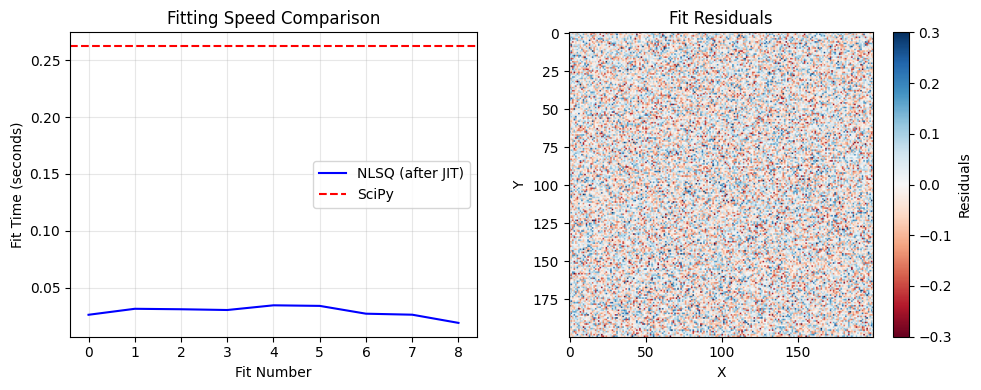


Residuals RMS: 0.0997


In [13]:
if all_results and len(times) > 1:
    # Plot fit times
    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    plt.plot(times[1:], "b-", label="NLSQ (after JIT)")
    plt.axhline(y=scipy_time, color="r", linestyle="--", label="SciPy")
    plt.xlabel("Fit Number")
    plt.ylabel("Fit Time (seconds)")
    plt.title("Fitting Speed Comparison")
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Plot fitted vs true data
    plt.subplot(1, 2, 2)
    fitted_data = gaussian2d(XY_tuple, *popt_nlsq).reshape(length, length)
    residuals = zdata - fitted_data

    plt.imshow(residuals, cmap="RdBu", vmin=-0.3, vmax=0.3)
    plt.colorbar(label="Residuals")
    plt.title("Fit Residuals")
    plt.xlabel("X")
    plt.ylabel("Y")

    plt.tight_layout()
    plt.show()

    print(f"\nResiduals RMS: {np.sqrt(np.mean(residuals**2)):.4f}")

## Troubleshooting

If you encounter GPU errors:

1. **cuSolver Errors**: The notebook now includes automatic CPU fallback
2. **Out of Memory**: Reduce the `length` parameter or restart the runtime
3. **Force CPU**: Uncomment the `JAX_PLATFORMS='cpu'` line in the configuration cell
4. **Colab Specific**: Use Runtime → Restart runtime if GPU issues persist

The implementation now includes:
- Automatic GPU/CPU fallback for SVD operations
- Better memory management
- More robust error handling